<a href="https://colab.research.google.com/github/4jVb/friday-for-2morrow/blob/main/tutorial_dise%C3%B1o_3_gfp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Tutorial 3](https://github.com/evolutionaryscale/esm/tree/main/cookbook/tutorials): Diseño de una candidata a GFP con ESM3

Este notebook explica los métodos computacionales utilizados para diseñar esmGFP según lo descrito en [Hayes et al., 2024](https://doi.org/10.1101/2024.07.01.600583). esmGFP tiene un brillo y propiedades espectrales similares a las GFP naturales, a pesar de estar bastante alejada en secuencia (58% de identidad) de las proteínas fluorescentes conocidas. Sin embargo, también encontramos muchas otras nuevas GFP brillantes con una identidad de secuencia similar o incluso mayor. ¡Probablemente se puedan diseñar muchas más nuevas GFP usando el enfoque descrito en este cuaderno!

Este notebook implementa el prompt principal utilizado para iniciar la cadena de razonamiento que llevó a la creación de esmGFP. El proceso completo que seguimos difiere en dos aspectos clave:

1. Continuamos el proceso de generación más allá de lo que se muestra aquí,
realizando una optimización conjunta de la secuencia y la estructura generadas.

2. Usamos una cantidad de cómputo significativamente mayor de lo que es práctico en un cuaderno,
para generar múltiples diseños y filtrarlos mediante un conjunto de filtros computacionales y mecanismos de ranking.

También validamos experimentalmente en wet lab una pequeña cantidad de los diseños generados, lo cual, por supuesto, también puedes hacer tú... ¡aunque este notebook no es muy útil para esa parte!




## Configurar el notebook y el modelo (a través de la API de Forge).

Comenzamos instalando el [paquete esm](https://github.com/evolutionaryscale/esm) y py3Dmol, lo cual nos permitirá visualizar nuestras generaciones, y luego importamos los paquetes necesarios.


In [ ]:
from IPython.display import clear_output

!pip install git+https://github.com/evolutionaryscale/esm.git
!pip install py3Dmol

clear_output()  # Suppress pip install log lines after installation is complete.

In [ ]:
from getpass import getpass

import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.graphics as graphics
import matplotlib.pyplot as pl
import py3Dmol
import torch
from esm.sdk import client
from esm.sdk.api import ESMProtein, GenerationConfig
from esm.utils.structure.protein_chain import ProteinChain

ESM3 es un modelo generativo de frontera para la biología. Es escalable debido a su capacidad para tokenizar secuencia, estructura y función, y utilizar una arquitectura transformer (casi estándar) mientras sigue siendo capaz de razonar a través de todas las modalidades simultáneamente.

El ESM3 más grande (98 mil millones de parámetros) fue entrenado con 1.07e24 FLOPs en 2.78 mil millones de proteínas y 771 mil millones de tokens únicos. Para crear esmGFP usamos la variante de ESM3 con 7 mil millones de parámetros. Usaremos este modelo a través de la API de [EvolutionaryScale Forge](https://forge.evolutionaryscale.ai).

Obtén un token desde [la consola de Forge](https://forge.evolutionaryscale.ai/console) y agrégalo abajo. Ten en cuenta que tu token es como una contraseña para tu cuenta y debes protegerlo cuidadosamente. Por esta razón, se recomienda crear un nuevo token con frecuencia y eliminar los antiguos que no se usen. También se recomienda pegar el token directamente en una variable de entorno o usar una utilidad como `getpass`, como se muestra a continuación, para evitar que los tokens se compartan o se registren accidentalmente en repositorios de código.


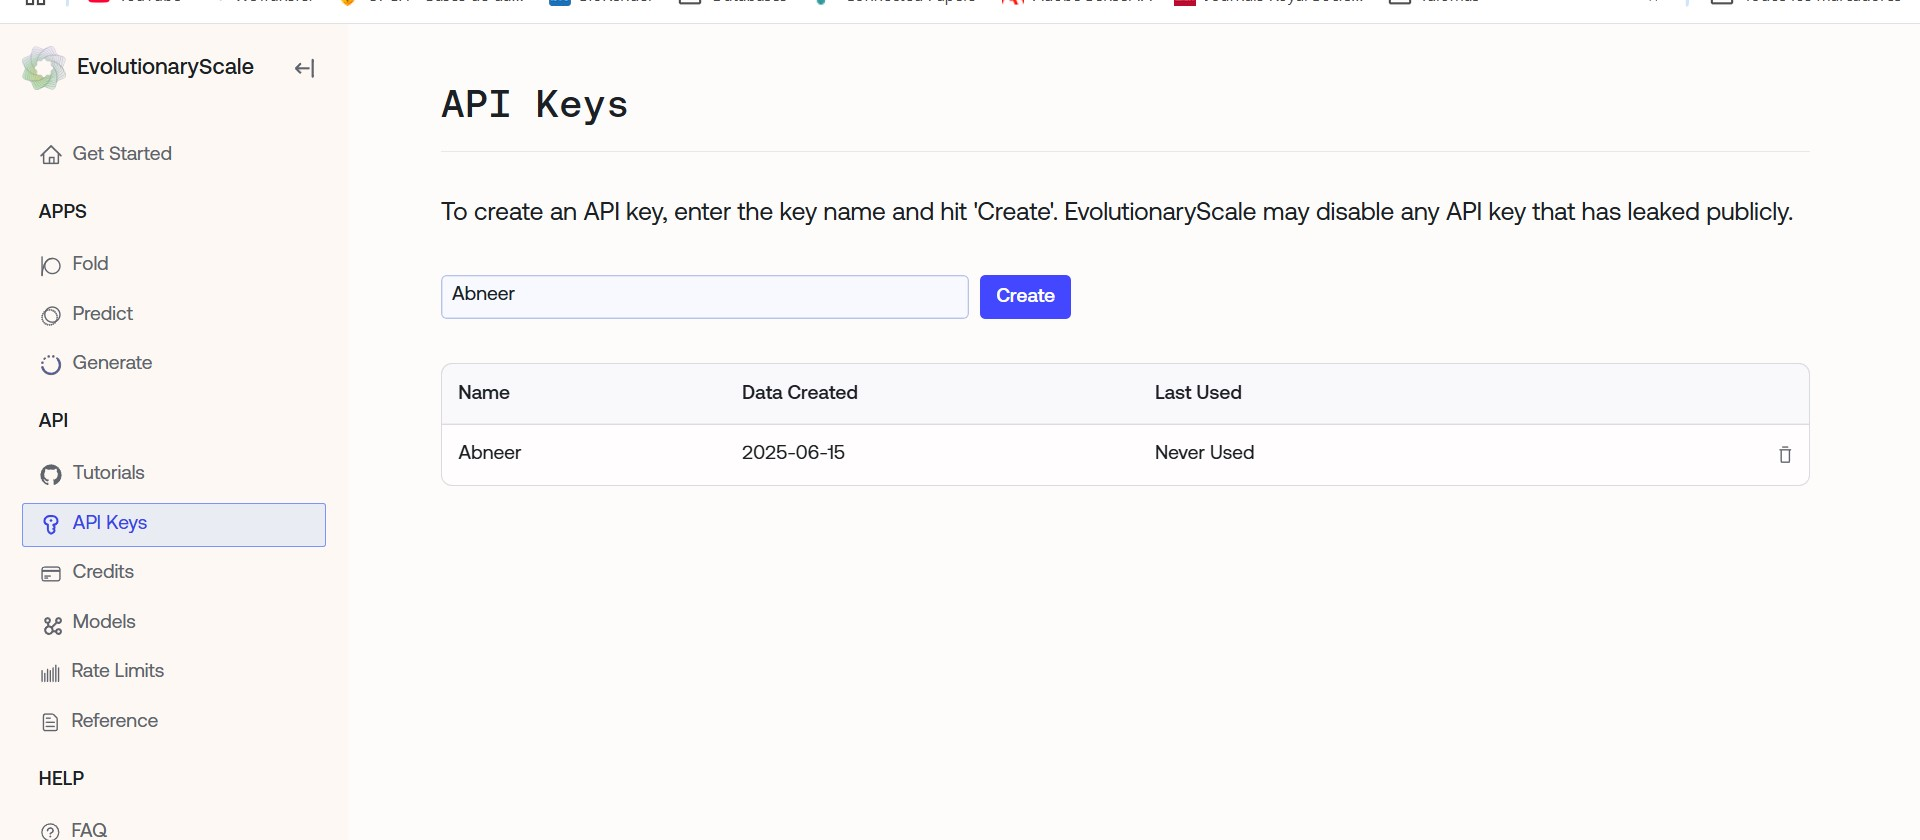

In [ ]:
token = getpass("Token from Forge console: ")

Luego creamos una estructura de modelo (model stub) que se comporta de forma similar a un modelo de PyTorch, pero en el fondo envía las entradas al servidor de Forge, ejecuta las entradas a través de los pesos de la red neuronal en ese servidor remoto, y luego devuelve los tensores de salida aquí en este notebook. Esta estructura también puede usarse en el SDK de EvolutionaryScale para simplificar muchas de las operaciones relacionadas con la generación, el plegamiento y, en general, el uso del muestreo. Esto es importante porque el muestreo iterativo es clave para obtener el mejor rendimiento de ESM3, y el SDK gestiona gran parte de la complejidad relacionada con la implementación de estas rutinas estándar.


In [ ]:
model = client(
    model="esm3-medium-2024-03", url="https://forge.evolutionaryscale.ai", token=token
)

## Construir el Prompt para la GFP


ESM3 es un modelo generativo. Para acceder a sus capacidades generativas, necesitamos familiarizarnos con la construcción de prompts (indicaciones). ESM3 razona conjuntamente sobre la secuencia, la estructura y la función de las proteínas, por lo que podemos construir nuevos tipos de prompts que guíen al modelo para generar proteínas con un nivel de control superior al de muchos otros modelos de lenguaje biológico.

Las modalidades de secuencia, estructura y función están representadas como pistas (tracks) de tokens discretos que están presentes tanto en la entrada como en la salida del modelo, y que se fusionan en un único espacio latente dentro del modelo. ESM3 se entrena con un objetivo generativo de modelado de lenguaje enmascarado (masked language modeling) con tasas de enmascaramiento variables, por lo que podemos generar prompts con contexto completamente o parcialmente enmascarado y aplicar diferentes puntos de condicionamiento en las diversas pistas. ¡Esto nos da la oportunidad de ser muy creativos a la hora de especificar nuestros prompts!

La ingeniería de prompts es un poco arte y un poco ciencia, así que normalmente hay que experimentar para obtener un prompt que produzca el resultado deseado. Además, como usamos muestreo para generar desde el modelo, los resultados de distintas generaciones usando el mismo prompt pueden variar. Algunos prompts tienden a tener tasas de éxito más altas y solo requieren unas pocas generaciones para obtener un diseño proteico candidato. Otros prompts más difíciles pueden requerir ¡miles de generaciones! Los modelos alineados ofrecen mayor control.

El modelo que vamos a usar es el modelo crudo preentrenado (no alineado), pero hemos trabajado bastante en este prompt, así que normalmente se puede obtener un diseño interesante con solo unas pocas generaciones.


## Construir el Prompt de GFP

Construiremos nuestro *prompt* a partir de fragmentos de la secuencia y estructura de [1qy3](https://www.rcsb.org/structure/1qy3) del PDB. El siguiente código obtiene datos del PDB y luego utiliza los tokenizadores de ESM3 para convertir la secuencia y la estructura en *tokens* que pueden ser pasados al modelo.

Se puede observar que tanto el tipo de aminoácido como las coordenadas son convertidos en un token discreto por cada posición de la secuencia.


In [ ]:
template_gfp = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb("1qy3", chain_id="A")
)
template_gfp_tokens = model.encode(template_gfp)

print("Sequence tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.sequence.tolist()])
)

print("Structure tokens:")
print(
    "    ", ", ".join([str(token) for token in template_gfp_tokens.structure.tolist()])
)

Ahora construiremos un *prompt*. Específicamente, indicaremos 4 identidades de aminoácidos en posiciones cercanas al sitio donde queremos que se forme el cromóforo, y 2 identidades de aminoácidos en el barril beta que se sabe que apoyan la formación del cromóforo.

Además, especificaremos que la estructura debe ser similar a la estructura 1qy3 en todas estas posiciones, añadiendo *tokens* de la estructura codificada de 1qy3 a la pista de estructura (*structure track*) de nuestro *prompt*. También especificaremos algunas posiciones adicionales (a lo largo del quiebre de la hélice alfa).


In [ ]:
prompt_sequence = ["_"] * len(template_gfp.sequence)
prompt_sequence[59] = "T"
prompt_sequence[62] = "T"
prompt_sequence[63] = "Y"
prompt_sequence[64] = "G"
prompt_sequence[93] = "R"
prompt_sequence[219] = "E"
prompt_sequence = "".join(prompt_sequence)

print(template_gfp.sequence)
print(prompt_sequence)

prompt = model.encode(ESMProtein(sequence=prompt_sequence))

# We construct an empty structure track like |<bos> <mask> ... <mask> <eos>|...
prompt.structure = torch.full_like(prompt.sequence, 4096)
prompt.structure[0] = 4098
prompt.structure[-1] = 4097
# ... and then we fill in structure tokens at key residues near the alpha helix
# kink and at the stabilizing R and E positions on the beta barrel.
prompt.structure[55:70] = template_gfp_tokens.structure[56:71]
prompt.structure[93] = template_gfp_tokens.structure[93]
prompt.structure[219] = template_gfp_tokens.structure[219]

print("".join(["✔" if st < 4096 else "_" for st in prompt.structure]))

La salida muestra la secuencia original de 1qy3 y nuestra pista de secuencia del *prompt* con las identidades de aminoácidos, así como las posiciones que tienen un *token* en la pista de estructura. Luego, se le pedirá a ESM3 que complete la estructura y la secuencia en las posiciones restantes que están enmascaradas (subrayadas).

Una pequeña nota: introdujimos la mutación A93R en nuestro *prompt*. Esto no es un error. Usar alanina en esta posición hace que el cromóforo madure extremadamente lento (¡lo cual es útil para medir la estructura pre-ciclada de la GFP!). Sin embargo, no queremos esperar a que nuestras GFP brillen, así que usamos arginina en esta posición.


## Generar una estructura

Luego damos el *prompt* al modelo y decodificamos la pista de *tokens* de estructura. Esto es similar a crear un andamiaje del esqueleto (backbone) para un *prompt* de sitio activo, pero hay algunas diferencias sutiles. Por ejemplo, como ya hemos especificado algunos de los *tokens* de estructura (por ejemplo, alrededor del sitio activo y residuos clave correspondientes), el modelo literalmente genera alrededor de esta estructura.

Los *tokens* se muestrean de manera iterativa desde ESM3.
Pueden muestrearse uno por uno, o en paralelo, en cualquier orden, hasta que todas las posiciones estén completamente desenmascaradas. La función `generate()` del SDK de EvolutionaryScale implementa una receta que creemos es efectiva para muestrear del modelo.


In [ ]:
%%time

num_tokens_to_decode = min((prompt.structure == 4096).sum().item(), 20)


structure_generation = model.generate(
    prompt,
    GenerationConfig(
        # Generate a structure.
        track="structure",
        # Sample one token per forward pass of the model.
        num_steps=num_tokens_to_decode,
        # Sampling temperature trades perplexity with diversity.
        temperature=1.0,
    ),
)

print("These are the structure tokens corresponding to our new design:")
print(
    "    ", ", ".join([str(token) for token in structure_generation.structure.tolist()])
)

# Decodes structure tokens to backbone coordinates.
structure_generation_protein = model.decode(structure_generation)

Ahora visualicemos nuestra estructura generada. Probablemente se parecerá al familiar barril beta de la GFP alrededor de una hélice alfa.


In [ ]:
view = py3Dmol.view(width=1000, height=500)
view.addModel(
    structure_generation_protein.to_protein_chain().infer_oxygen().to_pdb_string(),
    "pdb",
)
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

En este punto, solo queremos continuar con la generación si este diseño es una coincidencia cercana con una GFP tipo silvestre en el sitio activo, tiene alguna diferencia estructural en toda la proteína (de lo contrario terminaría siendo muy similar en secuencia a la GFP tipo silvestre), y en general aún se parece a la estructura clásica de la GFP con una hélice alfa dentro de un barril beta.

Por supuesto, cuando se generan muchos diseños no podemos revisar cada uno manualmente, así que adoptamos algunos criterios automáticos de muestreo por rechazo basados en el RMSD estructural general y el RMSD del sitio restringido para verificar que nuestra estructura generada sea fiel al prompt. Si estas verificaciones se aprueban, entonces intentaremos diseñar una secuencia para esta estructura. Si no, se debe volver unas celdas arriba y generar otra estructura hasta que pase estas evaluaciones computacionales. (O no… ¡este es tu diseño de GFP!)


In [ ]:
constrained_site_positions = [59, 62, 63, 64, 93, 219]

template_chain = template_gfp.to_protein_chain()
generation_chain = structure_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "✅" if backbone_rmsd > 1.5 else "❌"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

# Diseño de Secuencia

Ahora tenemos un esqueleto (backbone) con cierta variación estructural pero que también coincide con el sitio restringido de la GFP, y queremos diseñar una secuencia que se pliegue en esta estructura. Podemos usar la generación anterior, que es exactamente nuestro prompt original más los nuevos tokens de estructura que representan el backbone, para volver a hacer un prompt a ESM3.

Una vez que hayamos diseñado una secuencia, querremos confirmar que dicha secuencia corresponde con nuestra estructura, así que eliminaremos todo el condicionamiento restante del prompt y plegaremos la secuencia. De manera conveniente con ESM3, plegar una secuencia simplemente consiste en generar un conjunto de tokens de estructura condicionados por la secuencia de aminoácidos. En este caso queremos la generación con mayor confianza del modelo (sin diversidad), por lo que muestreamos con una temperatura de cero.


In [ ]:
%%time

# Based on internal research, there's not a benefit to iterative decoding past 20 steps
num_tokens_to_decode = min((prompt.sequence == 32).sum().item(), 20)

sequence_generation = model.generate(
    # Generate a sequence.
    structure_generation,
    GenerationConfig(track="sequence", num_steps=num_tokens_to_decode, temperature=1.0),
)

# Refold
sequence_generation.structure = None
length_of_sequence = sequence_generation.sequence.numel() - 2
sequence_generation = model.generate(
    sequence_generation,
    GenerationConfig(track="structure", num_steps=1, temperature=0.0),
)

# Decode to AA string and coordinates.
sequence_generation_protein = model.decode(sequence_generation)

¡Ahora tenemos una secuencia candidata de GFP!


In [ ]:
sequence_generation_protein.sequence

Podemos alinear esta secuencia contra la plantilla original para ver qué tan similar es a la avGFP. También se podría querer buscarla contra todas las proteínas fluorescentes conocidas para evaluar la novedad de esta posible GFP.


In [ ]:
seq1 = seq.ProteinSequence(template_gfp.sequence)
seq2 = seq.ProteinSequence(sequence_generation_protein.sequence)

alignments = align.align_optimal(
    seq1, seq2, align.SubstitutionMatrix.std_protein_matrix(), gap_penalty=(-10, -1)
)

alignment = alignments[0]

identity = align.get_sequence_identity(alignment)
print(f"Sequence identity: {100*identity:.2f}%")

print("\nSequence alignment:")
fig = pl.figure(figsize=(8.0, 4.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax, alignment, symbols_per_line=45, spacing=2, show_numbers=True
)
fig.tight_layout()
pl.show()

Ahora volvemos a revisar nuestras métricas computacionales para el sitio restringido.  
Si vemos que el sitio restringido no coincide, entonces querríamos intentar diseñar la secuencia nuevamente.  
Si muchos intentos de diseñar una secuencia que coincida con la estructura fallan, entonces probablemente la estructura no sea fácilmente diseñable y podríamos querer rechazar también esta generación de estructura.

En este punto, el RMSD del esqueleto (backbone) no nos importa mucho, ¡siempre y cuando la secuencia sea lo suficientemente diferente como para satisfacer nuestra curiosidad científica!

In [ ]:
template_chain = template_gfp.to_protein_chain()
generation_chain = sequence_generation_protein.to_protein_chain()

constrained_site_rmsd = template_chain[constrained_site_positions].rmsd(
    generation_chain[constrained_site_positions]
)
backbone_rmsd = template_chain.rmsd(generation_chain)

c_pass = "✅" if constrained_site_rmsd < 1.5 else "❌"
b_pass = "🤷‍♂️"

print(f"Constrained site RMSD: {constrained_site_rmsd:.2f} Ang {c_pass}")
print(f"Backbone RMSD: {backbone_rmsd:.2f} Ang {b_pass}")

Y ahora podemos visualizar la predicción final de la estructura de nuestro diseño candidato de GFP.


In [ ]:
view = py3Dmol.view(width=600, height=600)
view.addModel(sequence_generation_protein.to_pdb_string(), "pdb")
view.setStyle({"cartoon": {"color": "lightgreen"}})
view.zoomTo()
view.show()

Antes de considerar esta secuencia para validación en laboratorio húmedo, realizamos una optimización conjunta de la secuencia y la estructura. Los resultados de ese proceso luego se someten a filtros computacionales rigurosos y, posteriormente, muchos diseños a partir de distintos puntos de inicio se clasifican según diversos puntajes computacionales para seleccionar los diseños finales que se enviarán para pruebas. Explicaremos ese proceso en otro cuaderno.


Si has llegado hasta aquí, vale la pena señalar que este no es el único método para hacer que ESM3 diseñe una GFP, sino simplemente el que usamos para reportar la generación exitosa de esmGFP en nuestro artículo. ¡Esperamos que pruebes diferentes técnicas para generar con ESM3! ¡Nos interesa saber qué te funciona!